# Transport for London Cycle Data


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.style.use("seaborn-whitegrid")


In [2]:
# Fetch data
cycle_data = pd.read_csv("TFLCycles/data/london_merged.csv")
# data retrieved from: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

# Change column names
col_mappings = {'cnt': 'count', 't1': 'temperature', 't2': 'temp_feels'}
print(cycle_data.shape)
cycle_data.rename(columns=col_mappings, inplace=True)
cycle_data.head()

(17414, 10)


timestamp  count  temperature  temp_feels    hum  wind_speed  \
0  2015-01-04 00:00:00    182          3.0         2.0   93.0         6.0   
1  2015-01-04 01:00:00    138          3.0         2.5   93.0         5.0   
2  2015-01-04 02:00:00    134          2.5         2.5   96.5         0.0   
3  2015-01-04 03:00:00     72          2.0         2.0  100.0         0.0   
4  2015-01-04 04:00:00     47          2.0         0.0   93.0         6.5   

   weather_code  is_holiday  is_weekend  season  
0           3.0         0.0         1.0     3.0  
1           1.0         0.0         1.0     3.0  
2           1.0         0.0         1.0     3.0  
3           1.0         0.0         1.0     3.0  
4           1.0         0.0         1.0     3.0

In [3]:
# Split timestamps
import datetime
# 2015-01-04 00:00:00
cycle_data['timestamp_obj'] = cycle_data['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

cycle_data['year'] = cycle_data['timestamp_obj'].apply(lambda x: x.year)
cycle_data['month'] = cycle_data['timestamp_obj'].apply(lambda x: x.month)
cycle_data['day'] = cycle_data['timestamp_obj'].apply(lambda x: x.day)
cycle_data['hour'] = cycle_data['timestamp_obj'].apply(lambda x: x.hour)
cycle_data['week_day'] = cycle_data['timestamp_obj'].apply(lambda x: x.weekday()+1)
cycle_data.head()

timestamp  count  temperature  temp_feels    hum  wind_speed  \
0  2015-01-04 00:00:00    182          3.0         2.0   93.0         6.0   
1  2015-01-04 01:00:00    138          3.0         2.5   93.0         5.0   
2  2015-01-04 02:00:00    134          2.5         2.5   96.5         0.0   
3  2015-01-04 03:00:00     72          2.0         2.0  100.0         0.0   
4  2015-01-04 04:00:00     47          2.0         0.0   93.0         6.5   

   weather_code  is_holiday  is_weekend  season       timestamp_obj  year  \
0           3.0         0.0         1.0     3.0 2015-01-04 00:00:00  2015   
1           1.0         0.0         1.0     3.0 2015-01-04 01:00:00  2015   
2           1.0         0.0         1.0     3.0 2015-01-04 02:00:00  2015   
3           1.0         0.0         1.0     3.0 2015-01-04 03:00:00  2015   
4           1.0         0.0         1.0     3.0 2015-01-04 04:00:00  2015   

   month  day  hour  week_day  
0      1    4     0         7  
1      1    4     1         7  
2      1    4     2         7  
3      1    4     3         7  
4      1    4     4         7

In [4]:
# Aggregate by day and plot against time
cycle_day_data = cycle_data[['year', 'month', 'day', 'week_day', 'count']].groupby(by=['year', 'month', 'day', 'week_day']).sum().reset_index()
cycle_day_data['datetime'] = cycle_day_data.apply(func=lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)
cycle_day_data = cycle_day_data[['datetime', 'count', 'year', 'month', 'day', 'week_day']]
cycle_day_data.head()

datetime  count  year  month  day  week_day
0  2015-01-04   9234  2015      1    4         7
1  2015-01-05  20372  2015      1    5         1
2  2015-01-06  20613  2015      1    6         2
3  2015-01-07  21064  2015      1    7         3
4  2015-01-08  15601  2015      1    8         4

## Things to explore
* Correlation of temperature/bad weather against counts
  * Higher correlation on weekends/holidays
* More journeys at rush hour
* Journeys increasing with time?

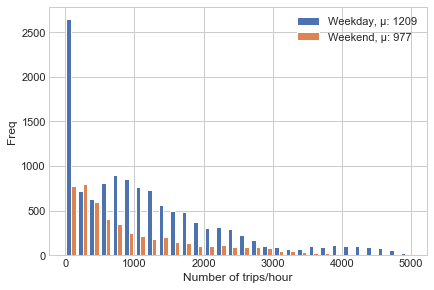

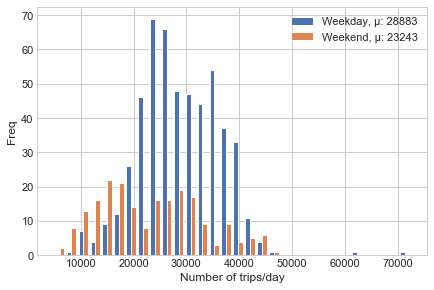

In [5]:
# More journeys per hour on weekends?
count_data = [cycle_data[cycle_data['is_weekend']==0]['count'], cycle_data[cycle_data['is_weekend']==1]['count']]
mean_counts = [np.mean(data) for data in count_data]
plt.hist(count_data, bins=30, range=(0, 5000), label=[f'Weekday, µ: {mean_counts[0]:.0f}', f'Weekend, µ: {mean_counts[1]:.0f}'])
plt.tight_layout()
plt.legend(loc='upper right')
plt.xlabel('Number of trips/hour')
plt.ylabel('Freq')
plt.show()

# By day
count_data = [cycle_day_data[~cycle_day_data['week_day'].isin([6, 7])]['count'], cycle_day_data[cycle_day_data['week_day'].isin([6, 7])]['count']]
mean_counts = [np.mean(data) for data in count_data]
plt.hist(count_data, bins=30, label=[f'Weekday, µ: {mean_counts[0]:.0f}', f'Weekend, µ: {mean_counts[1]:.0f}'])
plt.tight_layout()
plt.legend(loc='upper right')
plt.xlabel('Number of trips/day')
plt.ylabel('Freq')
plt.show()

/Users/Rich/Developer/Data Science/VariousDataAnalysis/dataAnalysisEnv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


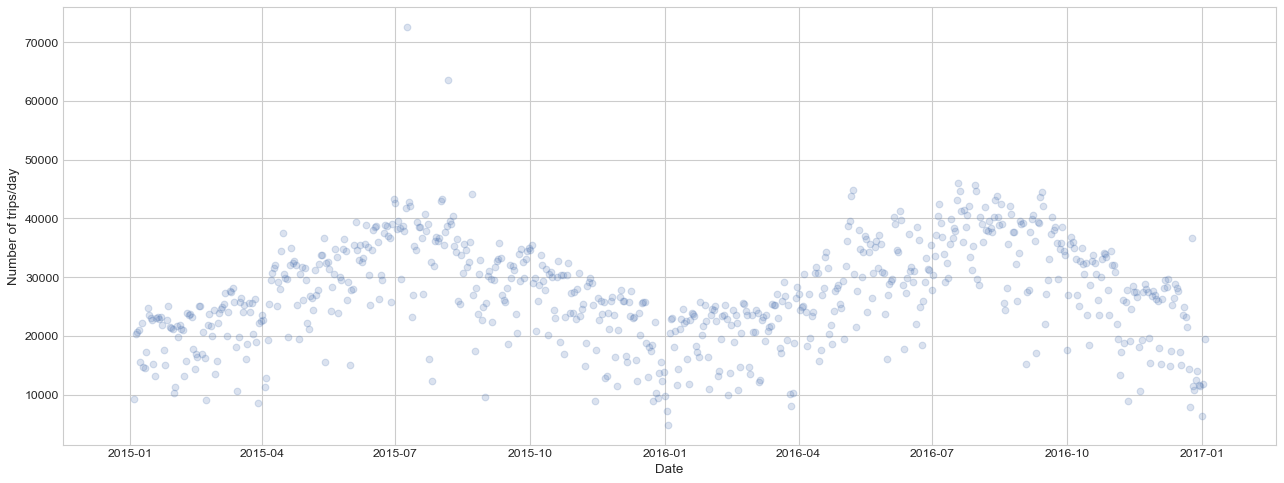

In [6]:
# Journeys increasing with time?
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(cycle_day_data['datetime'], cycle_day_data['count'], alpha=0.2)
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Number of trips/day')
plt.show()

# Maybe better to show change in totals per week year on year

# Journeys increasing with time?
# plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(cycle_data['timestamp_obj'], cycle_data['count'], alpha=0.2)
# plt.tight_layout()
# plt.xlabel('Date')
# plt.ylabel('Number of trips/hour')
# plt.show()

# Journeys by hour
The distribution is different weekday to weekend

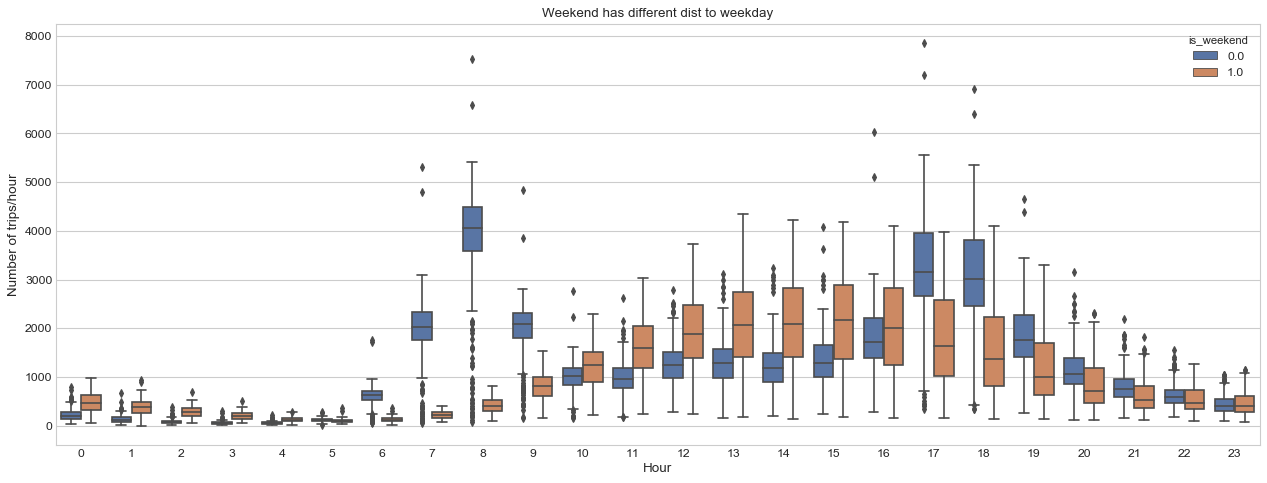

In [7]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x="hour", y="count", hue="is_weekend", data=cycle_data)
plt.tight_layout()
plt.xlabel('Hour')
plt.ylabel('Number of trips/hour')
plt.title('Weekend has different dist to weekday')
plt.show()

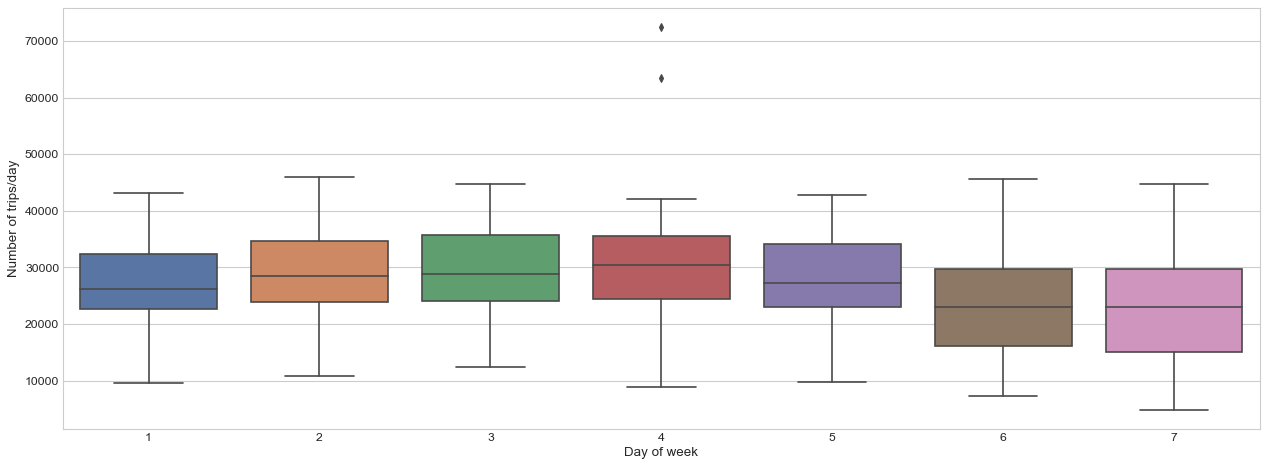

In [8]:
# Against week day
# Monday seems least popular work day to cycle, weekend less popular
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x="week_day", y="count", data=cycle_day_data)
plt.tight_layout()
plt.xlabel('Day of week')
plt.ylabel('Number of trips/day')
plt.show()

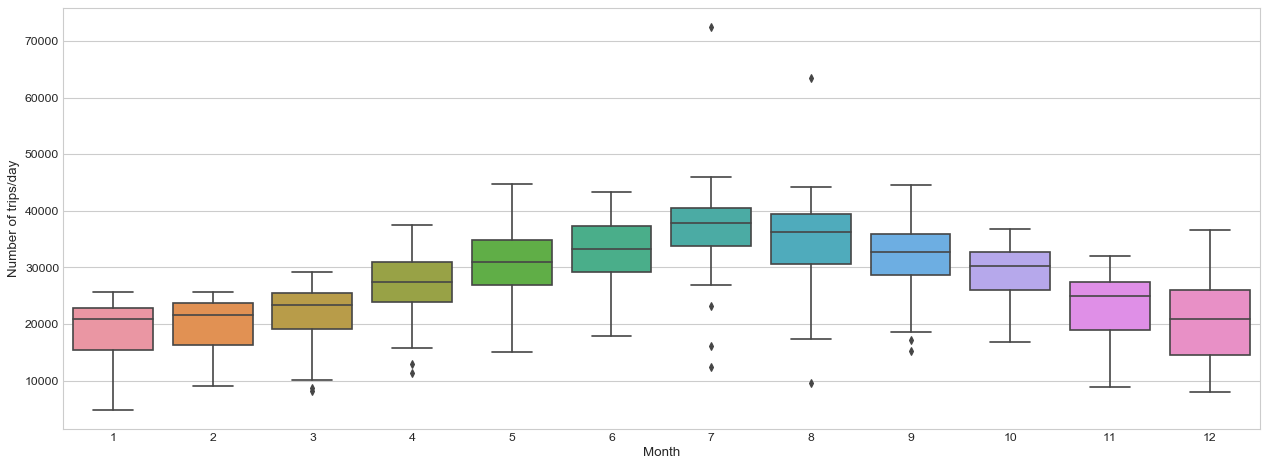

In [9]:
# Against month
# Winter months are less popular
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x="month", y="count", data=cycle_day_data)
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Number of trips/day')
plt.show()

# Does time of day change through out the year?
More later journeys in summer?  
When normalised over the day - a higher proportion of journeys are made later in the evening

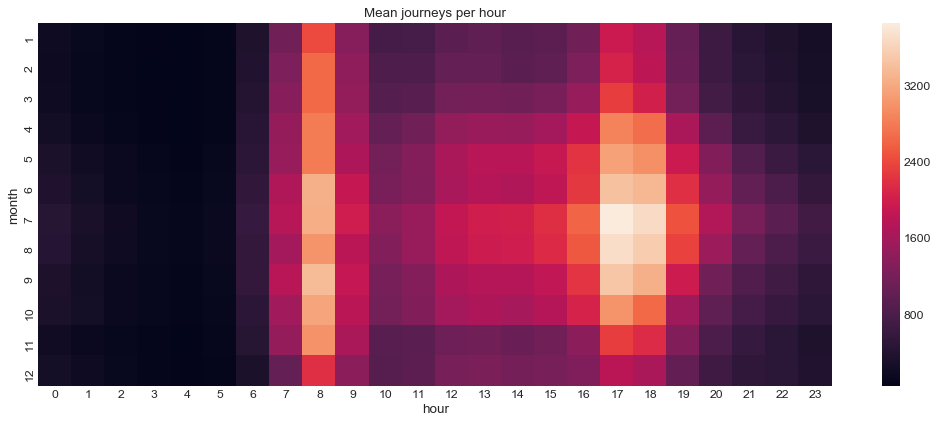

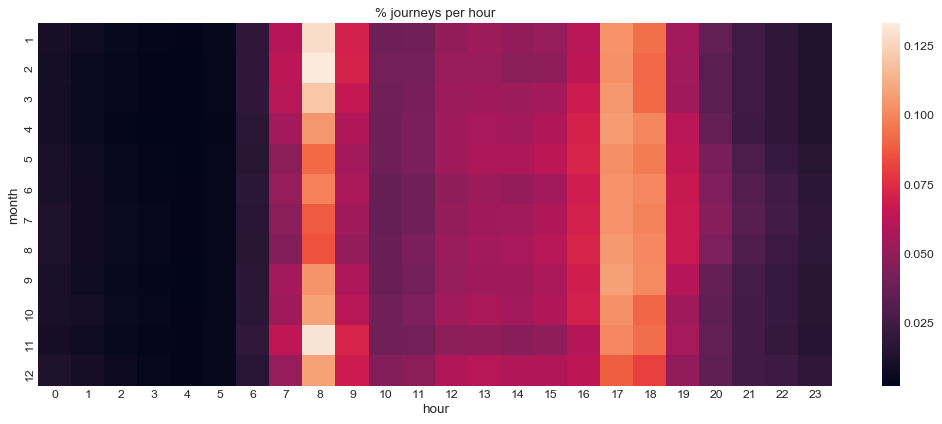

In [10]:
# Heat map against month/hour
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
agr_counts = cycle_data[['month', 'hour', 'count']].groupby(by=['month', 'hour'], axis=0).mean()
agr_counts_pivot = agr_counts.reset_index().pivot(index='month', columns='hour', values='count')
sns.heatmap(agr_counts_pivot)
plt.title('Mean journeys per hour')
plt.show()

# Normalise over the day - higher proportion of journeys made later in the evening
agr_counts_norm = agr_counts.groupby('month').transform(lambda x: (x/x.sum()))
agr_counts_norm_pivot = agr_counts_norm.reset_index().pivot(index='month', columns='hour', values='count')
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(agr_counts_norm_pivot)
plt.title('% journeys per hour')
plt.show()

# Does time of day change through out the week?
Friday has a more flat distribution of journey times and a lower early evening proportion and a higher later evening proportion  
Weekends dont exhibit a morning peak but longer evening tails

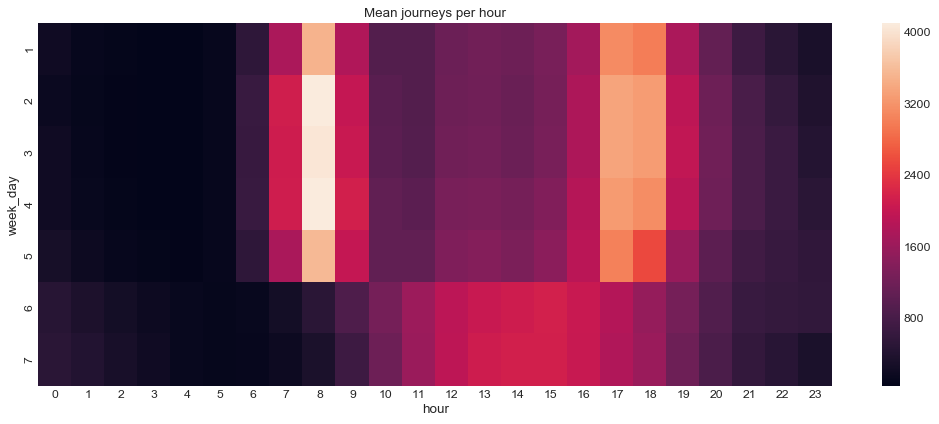

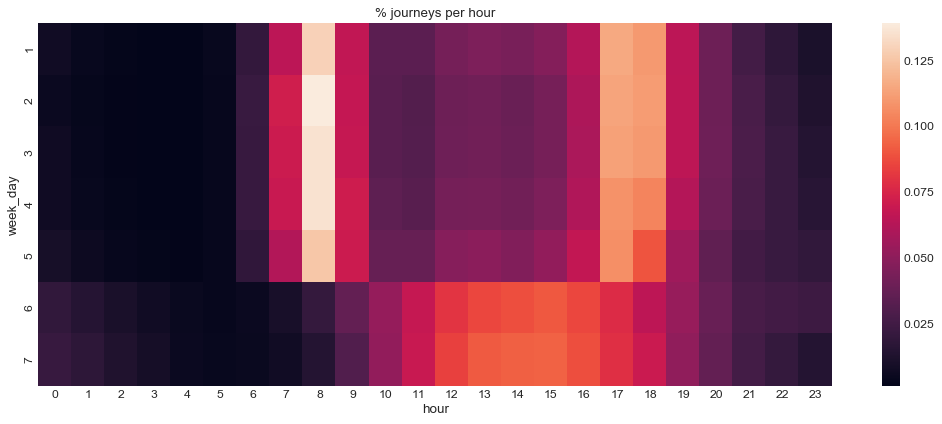

In [11]:
# Heat map against day/hour
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
agr_counts = cycle_data[['week_day', 'hour', 'count']].groupby(by=['week_day', 'hour'], axis=0).mean()
agr_counts_pivot = agr_counts.reset_index().pivot(index='week_day', columns='hour', values='count')
sns.heatmap(agr_counts_pivot)
plt.title('Mean journeys per hour')
plt.show()

# Normalise over the day - higher proportion of journeys made later in the evening
agr_counts_norm = agr_counts.groupby('week_day').transform(lambda x: (x/x.sum()))
agr_counts_norm_pivot = agr_counts_norm.reset_index().pivot(index='week_day', columns='hour', values='count')
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(agr_counts_norm_pivot)
plt.title('% journeys per hour')
plt.show()

# Relation to weather
Temperature/humdity/wind speed affects counts?  

'Real feel' temperature is very similar to temperature other than low temperatures so only using temp_feels for now  
No noticable difference against weekday/weekend - isnt clear whether on weekdays people endure the weather regardless  
High temperatures = more journeys  


"weather_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  
2 = scattered clouds / few clouds  
3 = Broken clouds  
4 = Cloudy  
7 = Rain/ light Rain shower/ Light rain  
10 = rain with thunderstorm  
26 = snowfall  
94 = Freezing Fog  

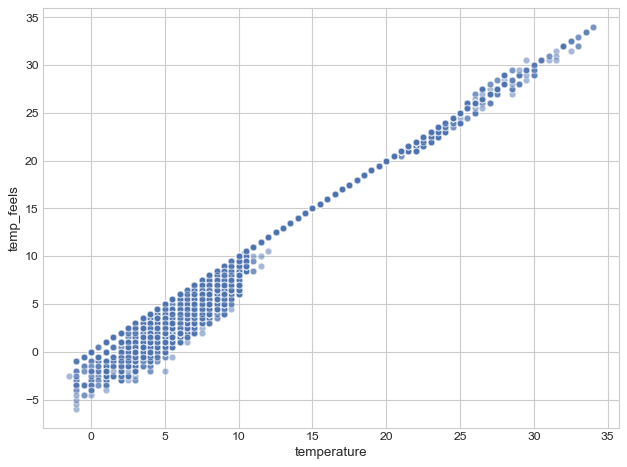

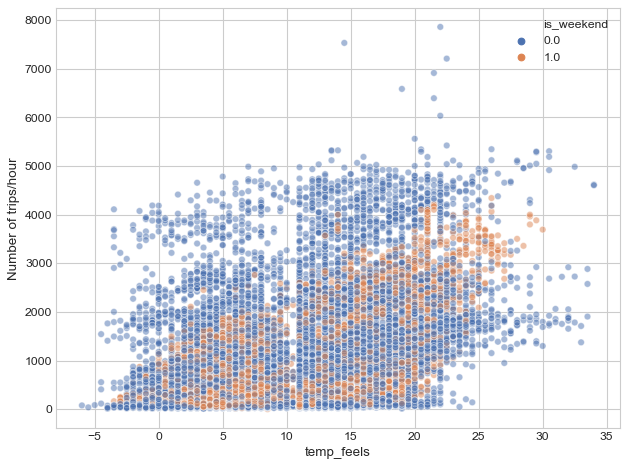

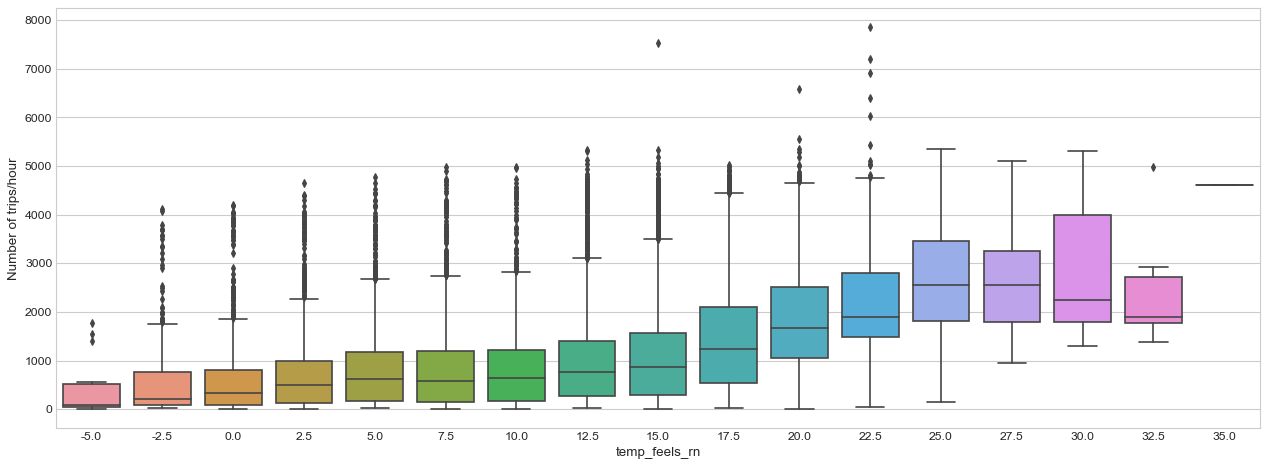

In [12]:
# temperature vs temp_feels
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.scatterplot(x='temperature', y='temp_feels', data=cycle_data, alpha=0.5)
plt.tight_layout()
plt.show()

# No clear pattern when splitting by weekend effects
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.scatterplot(x='temp_feels', y='count', hue='is_weekend', data=cycle_data, alpha=0.5)
plt.tight_layout()
plt.ylabel("Number of trips/hour")
plt.show()

# Wind speed?
# High speed fewer journies
# Low speed too - other confounding factors?

# High temperatures are correlat
group_size = 2.5
cycle_data['temp_feels_rn'] = (cycle_data['temp_feels']/group_size).round()*group_size
# .apply(lambda x: )
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x="temp_feels_rn", y="count", data=cycle_data)
plt.tight_layout()
#plt.xlabel('Month')
plt.ylabel('Number of trips/hour')
plt.show()


In [46]:
# Find average weather for each day
# Limit to day time only?
idx_cols = ['year', 'month', 'day', 'week_day']
f = {'count': 'sum',
    'temp_feels': 'mean',
    'wind_speed': 'mean',
    'hum': 'mean',
    'weather_code': pd.Series.mode}
cycle_day_data = cycle_data[idx_cols + list(f.keys())].groupby(by=idx_cols).agg(f).reset_index()
cycle_day_data['datetime'] = cycle_day_data.apply(func=lambda x: datetime.date(x['year'], x['month'], x['day']), axis=1)
cycle_day_data.head()


# Regress on count data to find coefficient for weather conditions to get effect size, need to account for seasonality first

year  month  day  week_day  count  temp_feels  wind_speed        hum  \
0  2015      1    4         7   9234    0.645833    7.500000  94.270833   
1  2015      1    5         1  20372    6.708333    8.854167  80.312500   
2  2015      1    6         2  20613    5.333333   16.000000  78.895833   
3  2015      1    7         3  21064    4.500000   19.760870  78.108696   
4  2015      1    8         4  15601    7.791667   20.479167  79.312500   

  weather_code    datetime  
0            3  2015-01-04  
1            3  2015-01-05  
2            1  2015-01-06  
3            2  2015-01-07  
4   [2.0, 7.0]  2015-01-08

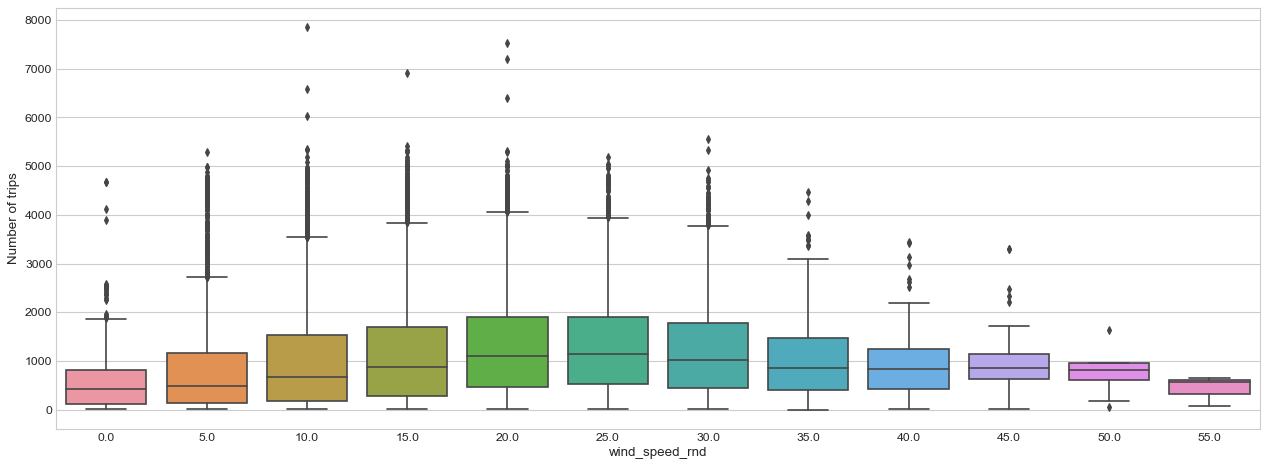

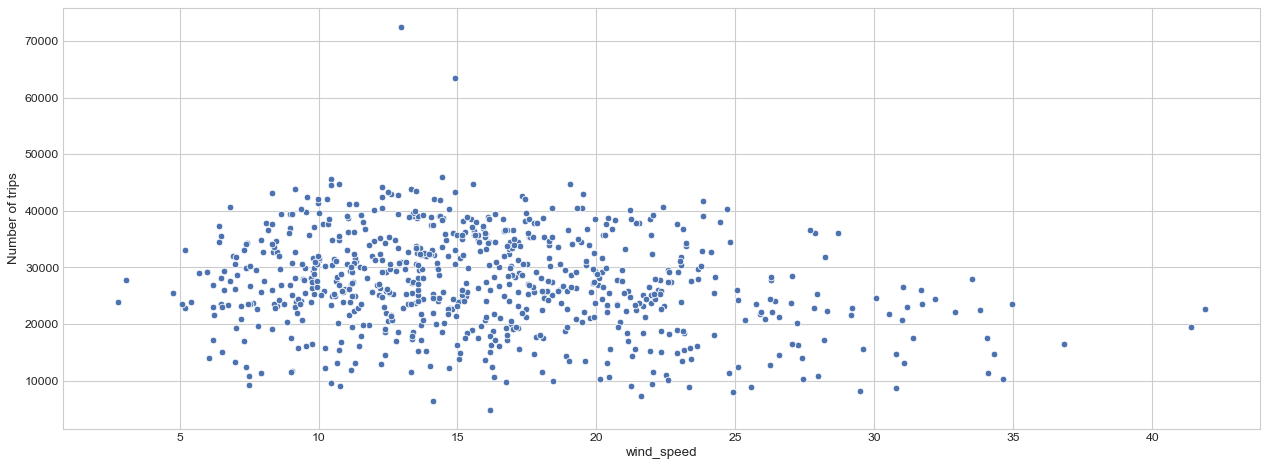

In [48]:
# Wind speed?
# High speed fewer journies
# Low speed too - other confounding factors?
group_size = 5.0
cycle_data['wind_speed_rnd'] = cycle_data['wind_speed']/group_size
cycle_data['wind_speed_rnd'] = cycle_data['wind_speed_rnd'].round()*group_size
# .apply(lambda x: )
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x="wind_speed_rnd", y="count", data=cycle_data)
plt.tight_layout()
#plt.xlabel('Month')
plt.ylabel('Number of trips')
plt.show()


plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
# sns.boxplot(x="wind_speed", y="count", data=cycle_day_data)
sns.scatterplot(x="wind_speed", y="count", data=cycle_day_data)
plt.tight_layout()
#plt.xlabel('Month')
plt.ylabel('Number of trips')
plt.show()

# plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# sns.scatterplot(x='temp_feels', y='count', hue='is_weekend', data=cycle_data, alpha=0.5)
# plt.tight_layout()
# plt.ylabel("Number of trips/hour")
# plt.show()


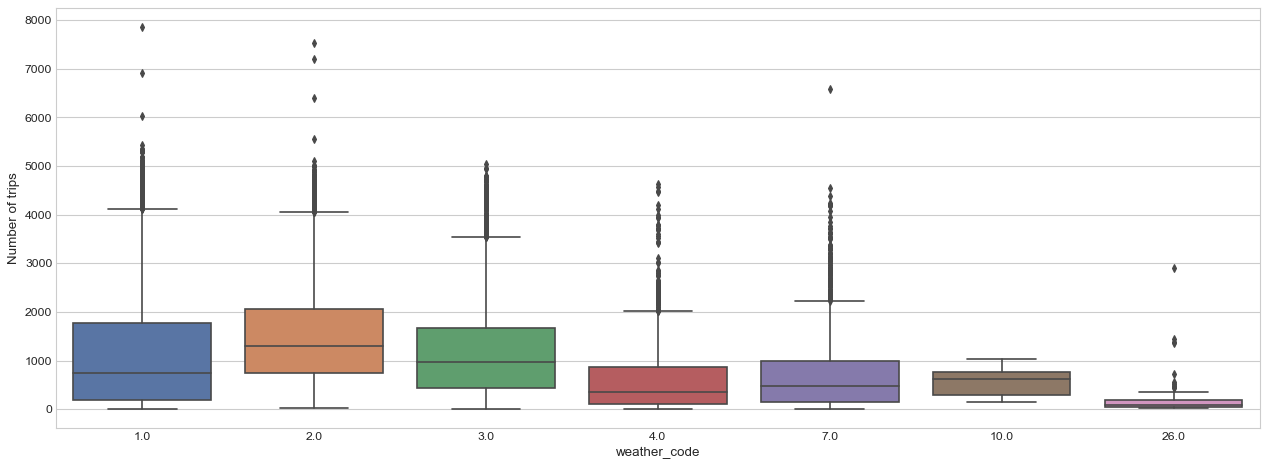


"weather_code" category description:

1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  

2 = scattered clouds / few clouds  

3 = Broken clouds  

4 = Cloudy  

7 = Rain/ light Rain shower/ Light rain  

10 = rain with thunderstorm  

26 = snowfall  

94 = Freezing Fog 
  



In [15]:
# Against weather type
# No one cycles in snow...
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
sns.boxplot(x="weather_code", y="count", data=cycle_data)
plt.tight_layout()
plt.ylabel('Number of trips')
plt.show()

print("""
"weather_code" category description:\n
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity  \n
2 = scattered clouds / few clouds  \n
3 = Broken clouds  \n
4 = Cloudy  \n
7 = Rain/ light Rain shower/ Light rain  \n
10 = rain with thunderstorm  \n
26 = snowfall  \n
94 = Freezing Fog \n  
""")

In [16]:
# g = sns.FacetGrid(cycle_data, row="weather_code", col="is_weekend", margin_titles=True)
# bins = np.linspace(0, 60, 13)
# g.map(plt.hist, "cnt", color="steelblue", bins=bins)

In [17]:
# g = sns.pairplot(cycle_data)